In [1]:
import torch
import rasterio
import numpy as np
import torchmetrics
import torch.nn as nn
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import random
import pathlib

import models
import utils.visualization as viz
from utils import SEN12MSDataset

simplified_igbp_cmap = colors.ListedColormap([
    "#009900",
    "#c6b044",
    "#fbff13",
    "#b6ff05",
    "#27ff87",
    "#c24f44",
    "#a5a5a5",
    "#69fff8",
    "#f9ffa4",
    "#1c0dff",
])

In [2]:
DATASET_PATH = pathlib.Path('../Data/SEN12MS/')

dataset = SEN12MSDataset(DATASET_PATH)

In [3]:
class FCDenseNet103(pl.LightningModule):

    def __init__(self):
        super(FCDenseNet103, self).__init__()

        self.densenet = models.FCDenseNet103(in_channels=12, n_classes=10)

        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy()

        self.train_data = None
        self.val_data = None

    def forward(self, x):
        x = self.densenet(x)
        return x

mmm = FCDenseNet103().cuda()
mmm.load_from_checkpoint('best_models/fcdensenet103_v0_val_acc=0.46.ckpt')
mmm.eval();

### Images from the dataset

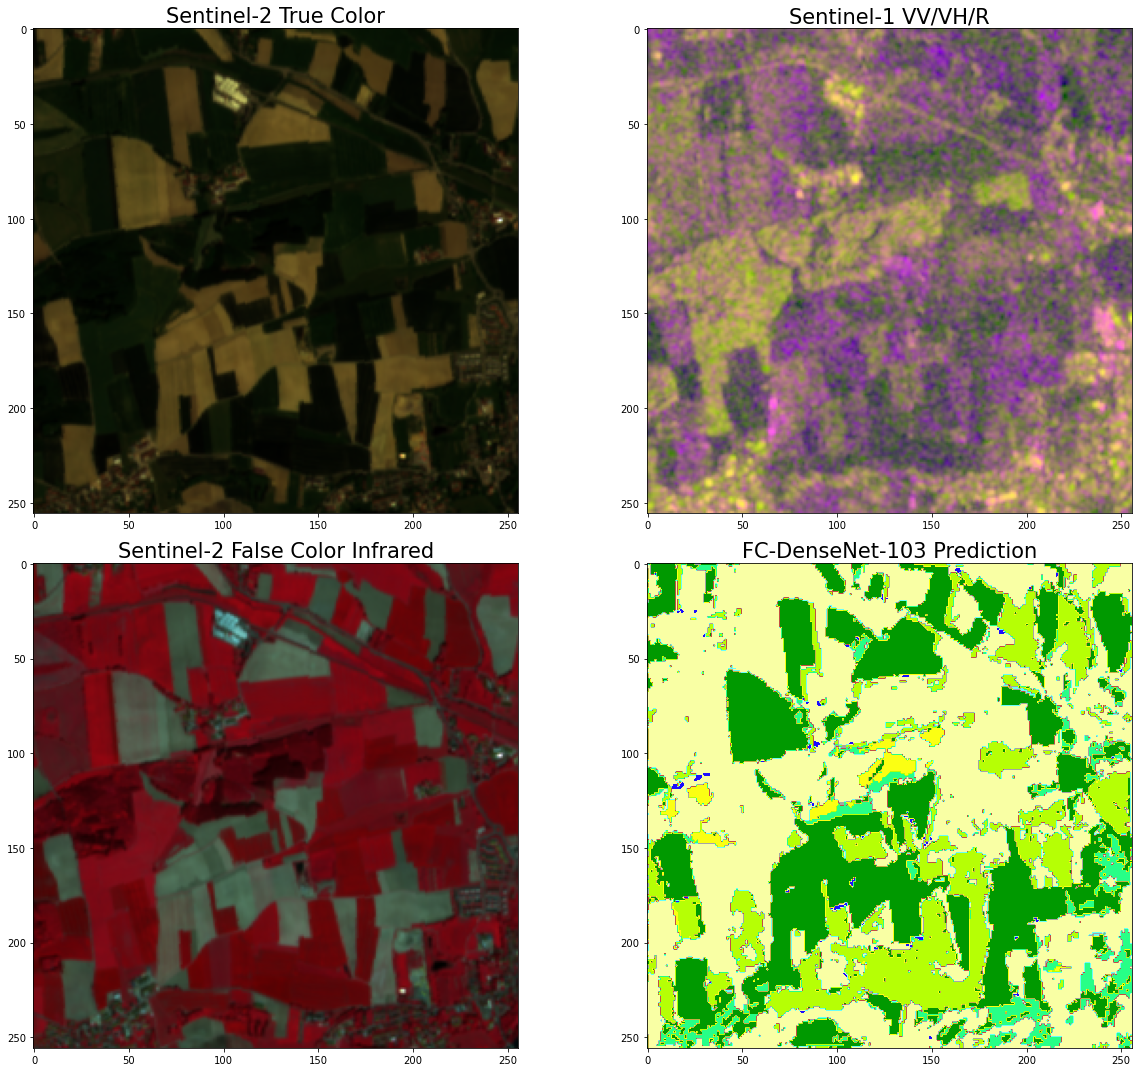

In [72]:
mmm = mmm.cpu()

index = random.randint(0, len(dataset) - 1)
x, y = dataset[index]

in_ = x.unsqueeze(0)
out = mmm(in_).squeeze().argmax(0).numpy()

s1 = x[:2].numpy()
s2 = x[2:].numpy()

fig, ax = plt.subplots(2, 2, figsize=(18, 15), tight_layout=True)

viz.plot_s2_rgb(s2, ax[0, 0])
viz.plot_s1_false_color_ratio(s1, ax[0, 1])
viz.plot_s2_fasle_color_infrared(s2, ax[1, 0])
ax[1, 1].imshow(out, cmap=simplified_igbp_cmap)

ax[0, 0].set_title('Sentinel-2 True Color', fontsize=21)
ax[0, 1].set_title('Sentinel-1 VV/VH/R', fontsize=21)
ax[1, 0].set_title('Sentinel-2 False Color Infrared', fontsize=21)
ax[1, 1].set_title('FC-DenseNet-103 Prediction', fontsize=21);

In [73]:
fig.savefig('results_densenet_dataset_4.png', dpi=300)

### Big test images

In [28]:
city = 'stpetersburg'  # munich, rome, stpetersburg

lc_path = pathlib.Path(f'../DLProject/test_images/{city}_landuse.tif')
s1_path = pathlib.Path(f'../DLProject/test_images/{city}_sentinel1.tif')
s2_path = pathlib.Path(f'../DLProject/test_images/{city}_sentinel2.tif')

with rasterio.open(lc_path) as tif:
    lc = tif.read()

with rasterio.open(s1_path) as tif:
    s1 = tif.read()

with rasterio.open(s2_path) as tif:
    s2 = tif.read()

In [29]:
lct = torch.from_numpy(lc)
s1t = torch.from_numpy(s1[:2])
s2t = torch.from_numpy(s2.astype(np.uint8))

height, width = lct.shape[1:]
window = 256

nh = height // window
nw = width // window

xx = torch.empty(12, height, width)
yy = torch.zeros(nh * window, nw * window)

xx[:2] = s1t
xx[2:] = s2t

In [37]:
xx = xx.cuda()
yy = yy.cuda()
total = nh * nw

for j in range(nh):
    for i in range(nw):
        in_ = xx[:, j * window : (j + 1) * window, i * window : (i + 1) * window]
        out = mmm(in_.unsqueeze(0)).squeeze().argmax(dim=0)
        yy[j * window : (j + 1) * window, i * window : (i + 1) * window] = out
        print(f'\rProcessing [{(j * nw + i + 1) / total * 100:.1f}%]', end='')

yy = yy.cpu().detach().numpy()

Processing [100.0%]

In [30]:
s1rgb = np.empty(shape=(3,) + s1.shape[1:])

s1rgb[0] = s1[0].clip(-35, 0)
s1rgb[1] = s1[1].clip(-35, 0)

s1rgb[2] = s1rgb[0] - s1rgb[1]
s1rgb[:2] = s1rgb[:2] - s1rgb[:2].min(axis=(1, 2), keepdims=True)
s1rgb[:2] = s1rgb[:2] / (s1rgb[:2].max(axis=(1, 2), keepdims=True) - s1rgb[:2].min(axis=(1, 2), keepdims=True))

s1rgb[2] = s1rgb[0] - s1rgb[1]
s1rgb[2] = s1rgb[2] - s1rgb[2].min(keepdims=True)
s1rgb[2] = s1rgb[2] / (s1rgb[2].max(keepdims=True) - s1rgb[2].min(keepdims=True))
s1rgb = np.transpose(s1rgb, [1, 2, 0])

s2rgb = s2[2::-1].clip(0, 2000)
s2rgb = s2rgb.clip(0, 5000)
s2rgb = s2rgb - s2rgb.min(axis=(1, 2), keepdims=True)
s2rgb = s2rgb / (s2rgb.max(axis=(1, 2), keepdims=True) - s2rgb.min(axis=(1, 2), keepdims=True))
s2rgb = np.transpose(s2rgb, [1, 2, 0])

infrared = s2[[6, 2, 1], ...].clip(0, 2000)
infrared -= infrared.min(axis=(1, 2), keepdims=True)
infrared = infrared / (infrared.max(axis=(1, 2), keepdims=True) - infrared.min(axis=(1, 2), keepdims=True))
infrared = np.transpose(infrared, [1, 2, 0])

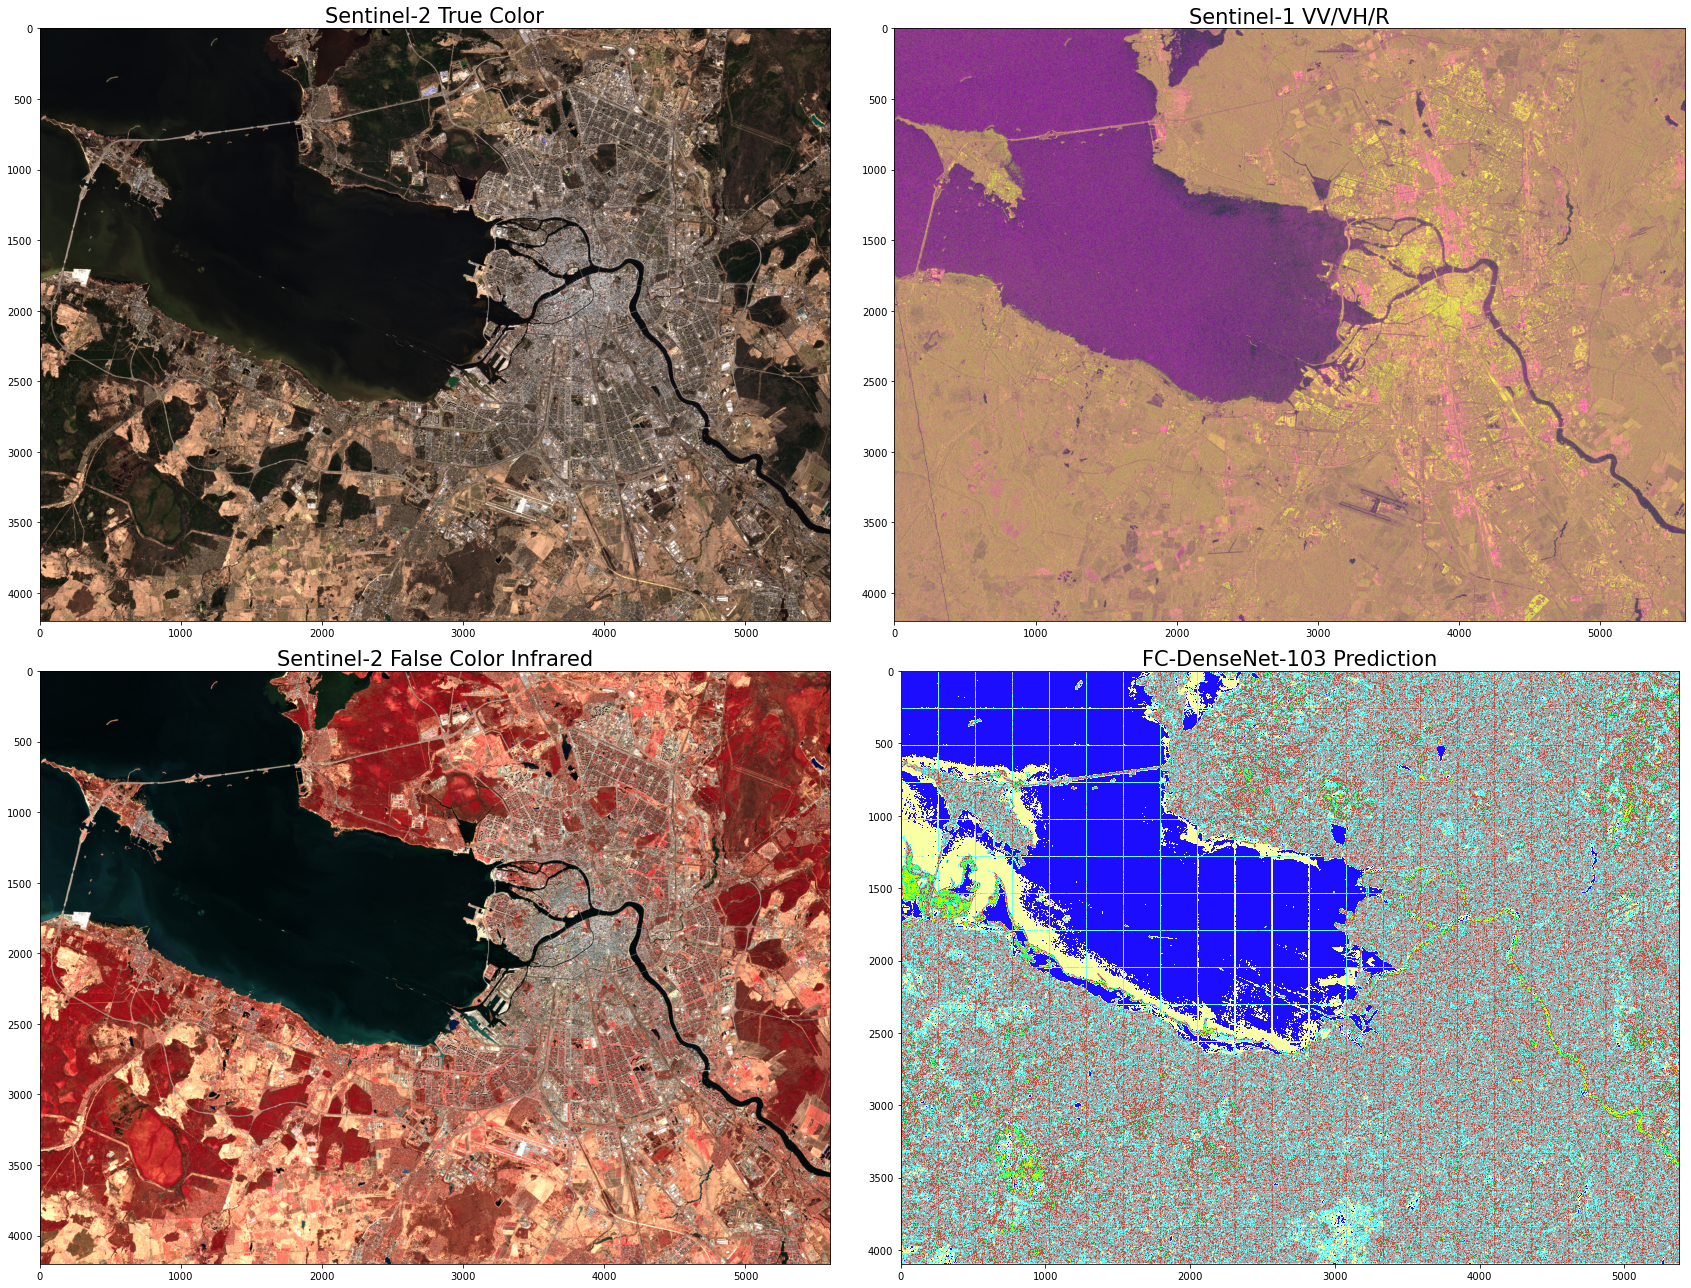

In [38]:
fig, ax = plt.subplots(2, 2, figsize=(24, 18), tight_layout=True)

ax[0, 0].imshow(s2rgb)
ax[0, 1].imshow(s1rgb)
ax[1, 0].imshow(infrared)
ax[1, 1].imshow(yy, cmap=simplified_igbp_cmap)

ax[0, 0].set_title('Sentinel-2 True Color', fontsize=21)
ax[0, 1].set_title('Sentinel-1 VV/VH/R', fontsize=21)
ax[1, 0].set_title('Sentinel-2 False Color Infrared', fontsize=21)
ax[1, 1].set_title('FC-DenseNet-103 Prediction', fontsize=21);

In [39]:
fig.savefig('results_densenet.png', dpi=300)

In [41]:
profile = tif.profile
profile.update(count=1, width=nw * window, height=nh * window)

with rasterio.open('prediction_densenet.tif', 'w', **profile) as dst:
    dst.write(yy.astype(np.uint16), 1)